In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,Lasso
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.pipeline import make_pipeline
from joblib import dump, load
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

# Read Data for System Validation
#Applied Volts for all IGBTs - Input (Features)
#Effective Amps on Panels - Output (Target)

In [12]:
#Validation Data Inputs/features
df_val=pd.read_csv('Data/System_Validation_Features.csv')#,index_col='time')
df_xval=df_val.loc[:,'09V':'Coulombs']
n_features=df_xval.columns.size
n_samples=df_xval.index.size
print(df_xval.shape)

#Validation Data Actual outputs/target
df_val_act=pd.read_csv('Data/System_Validation_Target_Actual.csv')#,index_col='time')
df_val_act

(159, 37)


,time,App_Amps,Coulombs,Front_A,Roof_A,RHWing_A,LHWing_A,Rear_A
0,0.0,67,134,12.850320,20.164238,13.201099,12.834800,7.949543
1,2.0,136,406,25.011072,42.417397,28.033778,26.170430,14.367323
2,4.0,179,764,26.693170,45.270142,29.919166,29.200068,47.917454
3,6.0,183,1130,17.650731,29.513051,20.204840,19.308406,96.322972
4,8.0,187,1504,9.514224,15.453813,10.664063,10.407756,140.960145
5,10.0,189,1882,7.074309,11.152734,7.760565,7.065765,155.946627
6,12.0,190,2262,6.109997,9.340590,6.702708,6.102617,161.744089
7,14.0,197,2656,5.766969,9.367202,6.326404,5.760004,169.779421
8,16.0,205,3066,5.887000,9.127522,6.432552,6.147157,177.405768
9,18.0,208,3482,6.128117,9.355563,6.404883,6.120716,179.990720


# Import created models for Calculating Total App Amps & Effective Amps

In [3]:
filename_Model_AppAmps='201019_ECModel_AppAmps.pkl'
filename_Model_EffAmps='081019_ECModel_EffAmps.pkl'
model_AppAmps=load(filename_Model_AppAmps) #Quadratic Ridge model
model_EffAmps=load(filename_Model_EffAmps) #Quadratic equation model

# Calculate App Amps & Coulombs from Applied Voltages

In [5]:
df_xval['Coulombs'] = 0.0
df_val['App_Amps']=0.0

for i in range(df_xval.index.size): #calculate applied voltages & coulombs one line at a time
    df_xval['Coulombs']=df_val['App_Amps'].mul(2)
    df_xval['Coulombs']=df_xval['Coulombs'].fillna(0)
    df_xval['Coulombs']=df_xval['Coulombs'].cumsum()
    xtest=df_xval.iloc[:(i+1),:].values #read features to a numpy array
    xtest.reshape((i+1),37) #reshape array (1 x n_features)
    y=model_AppAmps.predict(xtest) #using the model predict app for all IGBTs
    df_y=pd.DataFrame(data=y)
    #df_y[df_y < 0]=0
    df_val['App_Amps']=df_y.sum(axis=1)

df_val['Coulombs']=df_xval['Coulombs']

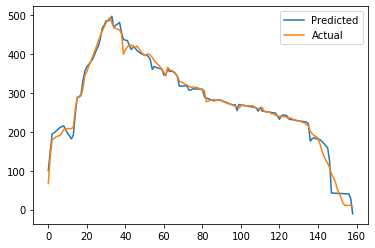

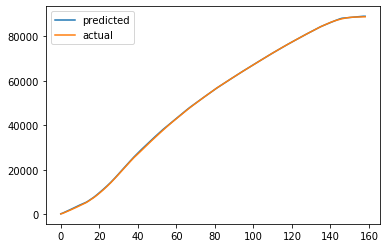

In [6]:
plt.plot(df_xval.index,df_val['App_Amps'],label='Predicted')
plt.plot(df_xval.index,df_val_act['App_Amps'],label='Actual')
plt.legend()
plt.show()

plt.plot(df_xval.index,df_val['Coulombs'],label='predicted')
plt.plot(df_xval.index,df_val_act['Coulombs'],label='actual')
plt.legend()
plt.show()

In [7]:
error_coulombs = df_val_act.loc[158,'Coulombs'] - df_val.loc[158,'Coulombs']
pct_error = (error_coulombs/df_val_act.loc[158,'Coulombs'])*100
print('error',error_coulombs)
print('pct Error',pct_error)

error -260.8864913201687
pct Error -0.29392349179829735


# Calculate the Effective Amps from Applied Amps

In [8]:
df_val.head()

,time,09V,10V,11V,12V,13V,14V,15V,16V,17V,...,37V,38V,39V,40V,41V,42V,43V,44V,Coulombs,App_Amps
0,0,99,100,100,99,0,0,0,0,0,...,0,0,0,0,0,0,0,0,200.942177,100.471088
1,2,181,181,181,181,0,0,0,0,0,...,0,0,0,0,0,0,0,0,499.347812,149.202818
2,4,214,211,240,240,0,0,0,0,0,...,0,0,0,0,0,0,0,0,887.965531,194.308860
3,6,209,206,240,240,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1282.595956,197.315212
4,8,206,203,240,240,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1684.810244,201.107144


In [9]:
dfx=df_val.loc[:,'Coulombs':'App_Amps']
dfx=dfx.reindex(columns=['App_Amps','Coulombs'])
xtest=dfx.values
xtest.reshape(159,2)
y=model_EffAmps.predict(xtest)
cols=['Front_A','Roof_A','RHWing_A','LHWing_A','Rear_A']
df_EffAmps=pd.DataFrame(data=y,columns=cols)

coulombs error: 934.7872296828446
coulombs pct_error: 5.7566152147833085


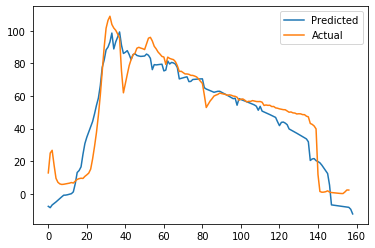

coulombs error: -1274.730184492253
coulombs pct_error: -8.405832693283948


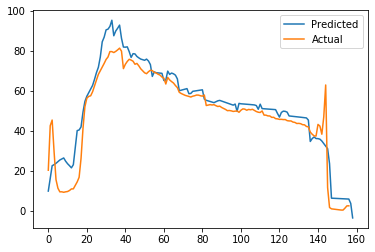

coulombs error: -1620.7749532550915
coulombs pct_error: -11.21072250853716


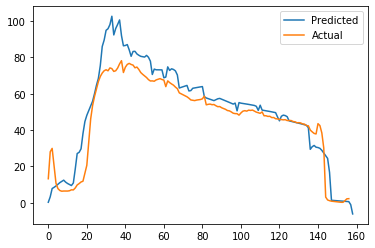

coulombs error: -1149.9576040471457
coulombs pct_error: -7.826624580946885


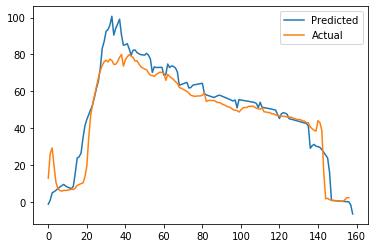

coulombs error: 2990.115704375603
coulombs pct_error: 10.6143787094022


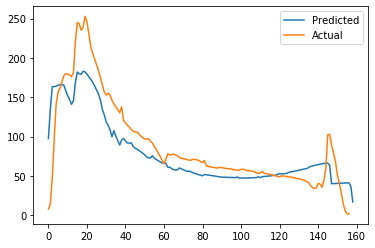

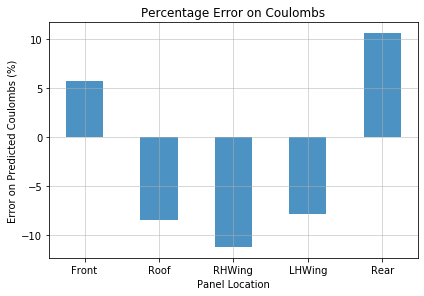

In [10]:
predicted=[None]*5
actual=[None]*5
errors=[None]*5
pct_errors=[None]*5
for i in range(df_EffAmps.columns.size):
    predicted[i]=df_EffAmps.iloc[:,i].mul(2).sum()
    actual[i]=df_val_act.iloc[:,(i+3)].mul(2).sum()
    errors[i]=actual[i]-predicted[i]
    pct_errors[i]=(errors[i]/actual[i])*100
    plt.plot(df_val_act.index,df_EffAmps.iloc[:,i],label='Predicted')
    plt.plot(df_val_act.index,df_val_act.iloc[:,(i+3)],label='Actual')
    print('coulombs error:',errors[i])
    print('coulombs pct_error:',pct_errors[i])
    plt.legend()
    plt.show()
    
n_groups=5
bar_width = 0.5
opacity=0.8
index = np.arange(n_groups)
plt.bar(index,pct_errors,bar_width,alpha=opacity)
plt.xlabel('Panel Location')
plt.ylabel('Error on Predicted Coulombs (%)')
plt.xticks(index, ('Front', 'Roof', 'RHWing', 'LHWing','Rear'))
plt.tight_layout()
plt.grid(linestyle='-', linewidth=0.5)
plt.title('Percentage Error on Coulombs')
plt.show()
    